In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import KFold
from tensorflow.keras import regularizers

In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import KFold
from tensorflow.keras import regularizers
!pip install ipywidgets
import ipywidgets as widgets
from IPython.display import display
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

In [3]:
train_img_path = r"C:\Users\pbans\OneDrive\Desktop\Capstone-Project\data3a\training"
test_img_path =  r'C:\Users\pbans\OneDrive\Desktop\Capstone-Project\data3a\validation'
batch_size = 32
img_height = 224
img_width = 224
train_data_gen = ImageDataGenerator(rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        validation_split=0.20,) 

# Use flow_from_directory for the training dataset
train_ds = train_data_gen.flow_from_directory(
    train_img_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  
    subset='training', 
    seed=123,
    shuffle=True  
)
valid_ds = train_data_gen.flow_from_directory(
    train_img_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  
    subset='validation', 
    seed=123,
    shuffle=True  
)

Found 1108 images belonging to 3 classes.
Found 275 images belonging to 3 classes.


Found 248 images belonging to 3 classes.
{'01-minor': 0, '02-moderate': 1, '03-severe': 2}


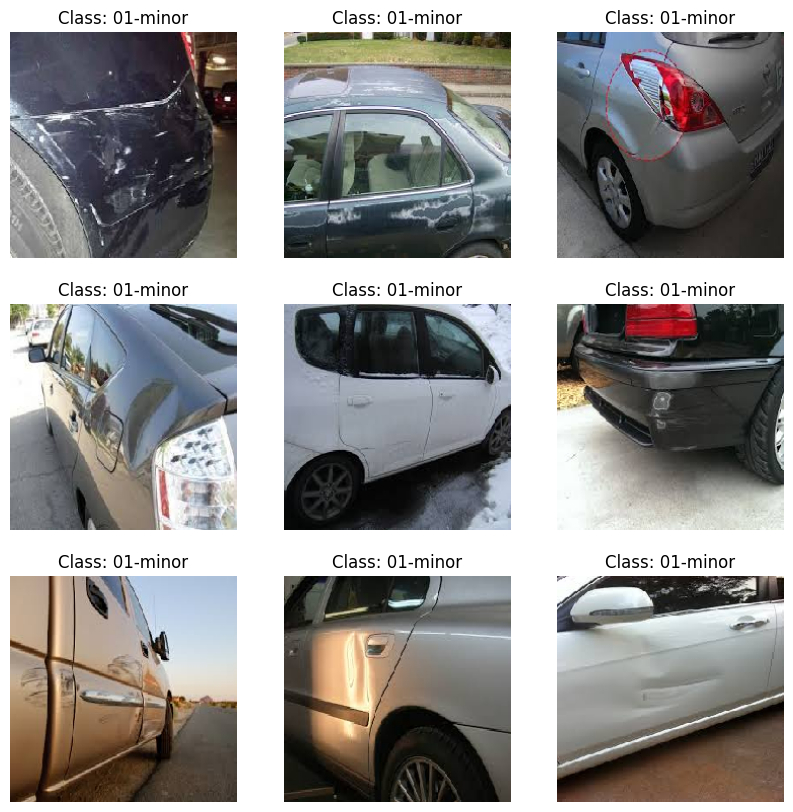

In [4]:
test_data_gen = ImageDataGenerator(rescale=1./255,)  # You may adjust other parameters as needed

# Use flow_from_directory for the test dataset
test_ds = test_data_gen.flow_from_directory(
    test_img_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Assuming label_mode='int' in your original code
    shuffle=False  # Set to True if you want to shuffle the data
)
cl=test_ds.class_indices
print(cl)
def plot_images_from_dataset(dataset, num_images=9):
    # Fetch a batch of images and labels from the dataset
    images, labels = next(iter(dataset))

    plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(images))):  
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        # Map the label index back to the original class name
        label_index = labels[i].argmax()  # Assumes one-hot encoding
        class_name = next(key for key, value in cl.items() if value == label_index)
        
        plt.title(f"Class: {class_name}")
        plt.axis("off")
    plt.show()


# Assuming test_ds is your dataset
plot_images_from_dataset(test_ds)


In [5]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
import tensorflow as tf

# Custom F1 Score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.cast(tf.round(y_pred), tf.bool)

        tp = tf.reduce_sum(tf.cast(y_true & y_pred, self.dtype))
        fp = tf.reduce_sum(tf.cast(~y_true & y_pred, self.dtype))
        fn = tf.reduce_sum(tf.cast(y_true & ~y_pred, self.dtype))

        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
    
    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

img_size = (224, 224)
lr = 0.001
class_count = 3

img_shape = (img_size[0], img_size[1], 3)

base_model = DenseNet169(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
base_model.trainable = True
x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(0.016), 
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=.4, seed=123)(x)
output = Dense(class_count, activation='softmax')(x)
model_eff = Model(inputs=base_model.input, outputs=output)
model_eff.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', 
                  metrics=['accuracy', 'AUC', F1Score()])

model_eff.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 13,076,547 (49.88 MB)

 Trainable params: 12,914,819 (49.27 MB)

 Non-trainable params: 161,728 (631.75 KB)

In [7]:
epochs=5

# Train the model
history_eff = model_eff.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds,  
    verbose=1,
)

# Save training and validation histories for later analysis
all_train_histories = [history_eff.history['accuracy']]
all_val_histories = [history_eff.history['val_accuracy']]

Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 188s 5s/step - AUC: 0.6027 - accuracy: 0.3963 - f1_score: 0.1340 - loss: 10.3684 - val_AUC: 0.5114 - val_accuracy: 0.3745 - val_f1_score: 0.3554 - val_loss: 396.7017
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 250s 7s/step - AUC: 0.5140 - accuracy: 0.3471 - f1_score: 0.0000e+00 - loss: 5.8994 - val_AUC: 0.4966 - val_accuracy: 0.3636 - val_f1_score: 0.2646 - val_loss: 52.6579
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 209s 6s/step - AUC: 0.4978 - accuracy: 0.3455 - f1_score: 0.0000e+00 - loss: 5.2170 - val_AUC: 0.5377 - val_accuracy: 0.3818 - val_f1_score: 0.1321 - val_loss: 15.6876
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 157s 4s/step - AUC: 0.5134 - accuracy: 0.3648 - f1_score: 0.0000e+00 - loss: 4.7851 - val_AUC: 0.5799 - val_accuracy: 0.3927 - val_f1_score: 0.0608 - val_loss: 8.3147
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 159s 5s/step - AUC: 0.4948 - accuracy: 0.3574 - f1_score: 0.0000e+00 - loss: 4.4633 - val_AUC: 0.5314 - val_accuracy: 0.3236 - val_f1_score: 0.058

In [8]:
import ipywidgets as widgets
from IPython.display import display
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess image
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to predict and display the image with its predicted class
def predict_and_display_image(image_path, model):
    # Preprocess the image
    processed_image = preprocess_image(image_path)
    
    # Make predictions
    predictions = model.predict(processed_image)
    
    # Get the predicted class label
    predicted_class_index = np.argmax(predictions)
    class_name = next(key for key, value in cl.items() if value == predicted_class_index)
    
    # Display the image with its predicted class
    img = load_img(image_path)
    plt.imshow(img)
    plt.title(f"Predicted Class: {class_name}")
    plt.axis("off")
    plt.show()

# Define the upload button and output widget
upload_btn = widgets.FileUpload(accept='image/*', multiple=False)
output = widgets.Output()

# Function to handle the image upload and classification
def on_upload_change(change):
    for filename, file_info in change['new'].items():
        # Save the uploaded image to a temporary path
        with open('uploaded_image.jpg', 'wb') as f:
            f.write(file_info['content'])
        
        # Display the image and prediction
        with output:
            output.clear_output()  # Clear previous outputs
            predict_and_display_image('uploaded_image.jpg', model_eff)

# Attach the function to the upload button
upload_btn.observe(on_upload_change, names='value')

# Display the upload button and output widget
display(upload_btn, output)


FileUpload(value=(), accept='image/*', description='Upload')

Output()

AttributeError: 'tuple' object has no attribute 'items'